In [10]:
import zipfile
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sys
import glob
import random
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use("dark_background")
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [11]:
DATAPATH="C:/Users/aisha/machine learning/lgg-mri-segmentation/kaggle_3m"
data_map = []
for sub_dir_path in glob.glob(os.path.join(DATAPATH, "*")):
    if os.path.isdir(sub_dir_path):
        dirname = os.path.basename(sub_dir_path)  
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.append([dirname, image_path])  
    else:
        print("This is not a dir:", sub_dir_path)

# Converting to DataFrame
df = pd.DataFrame(data_map, columns=['dirname', 'path'])
df.head()

This is not a dir: C:/Users/aisha/machine learning/lgg-mri-segmentation/kaggle_3m\data.csv
This is not a dir: C:/Users/aisha/machine learning/lgg-mri-segmentation/kaggle_3m\README.md


dirname                                               path
0  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...
1  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...
2  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...
3  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...
4  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...

In [12]:
# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

In [13]:
def extract_numeric(path, base_len, end_len):
    numeric_str = path[base_len:-end_len]
    numeric_part = re.findall(r'\d+', numeric_str)
    return int(''.join(numeric_part))

In [14]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x: extract_numeric(x, BASE_LEN, END_IMG_LEN))
masks = sorted(df_masks["path"].values, key=lambda x: extract_numeric(x, BASE_LEN, END_MASK_LEN))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: C:/Users/aisha/machine learning/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_19991127_6.tif 
Path to the Mask: C:/Users/aisha/machine learning/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_19991127_6_mask.tif


In [15]:
brain_df = pd.DataFrame({"patient_id": df_imgs.dirname.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['diagnosis'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df


patient_id  \
0     TCGA_CS_4941_19960909   
1     TCGA_CS_4941_19960909   
2     TCGA_CS_4941_19960909   
3     TCGA_CS_4941_19960909   
4     TCGA_CS_4941_19960909   
...                     ...   
3924  TCGA_HT_A61B_19991127   
3925  TCGA_HT_A61B_19991127   
3926  TCGA_HT_A61B_19991127   
3927  TCGA_HT_A61B_19991127   
3928  TCGA_HT_A61B_19991127   

                                             image_path  \
0     C:/Users/aisha/machine learning/lgg-mri-segmen...   
1     C:/Users/aisha/machine learning/lgg-mri-segmen...   
2     C:/Users/aisha/machine learning/lgg-mri-segmen...   
3     C:/Users/aisha/machine learning/lgg-mri-segmen...   
4     C:/Users/aisha/machine learning/lgg-mri-segmen...   
...                                                 ...   
3924  C:/Users/aisha/machine learning/lgg-mri-segmen...   
3925  C:/Users/aisha/machine learning/lgg-mri-segmen...   
3926  C:/Users/aisha/machine learning/lgg-mri-segmen...   
3927  C:/Users/aisha/machine learning/lgg-mri-segmen...   
3928  C:/Users/aisha/machine learning/lgg-mri-segmen...   

                                              mask_path  diagnosis  
0     C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
1     C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
2     C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
3     C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
4     C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
...                                                 ...        ...  
3924  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
3925  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
3926  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
3927  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
3928  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  

[3929 rows x 4 columns]

In [16]:
brain_df['diagnosis'].value_counts()

diagnosis
0    2556
1    1373
Name: count, dtype: int64

DATA VISUALIZATION

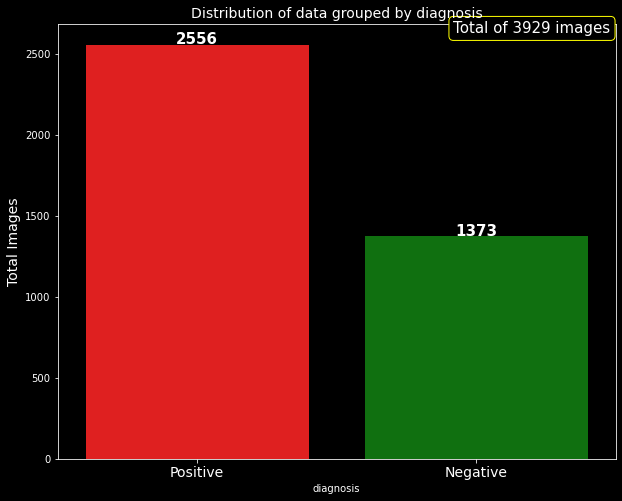

In [20]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='diagnosis', data=brain_df, palette=["red", "green"])
ax.set_title("Distribution of data grouped by diagnosis", fontsize=14)
ax.set_xticklabels(["Positive", "Negative"], fontsize=14);
plt.ylabel('Total Images', fontsize = 14)

for i, rows in enumerate(brain_df.diagnosis.value_counts().values): 
    ax.annotate(int(rows), xy=(i, rows-12),
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
ax.text(1.2, brain_df.diagnosis.value_counts().max() + 100,  # Position slightly above the max count
        f"Total of {len(brain_df)} images", size=15,
        color="white", ha="center", va="center",
        bbox=dict(boxstyle="round", fc="black", ec="yellow"))
plt.show()

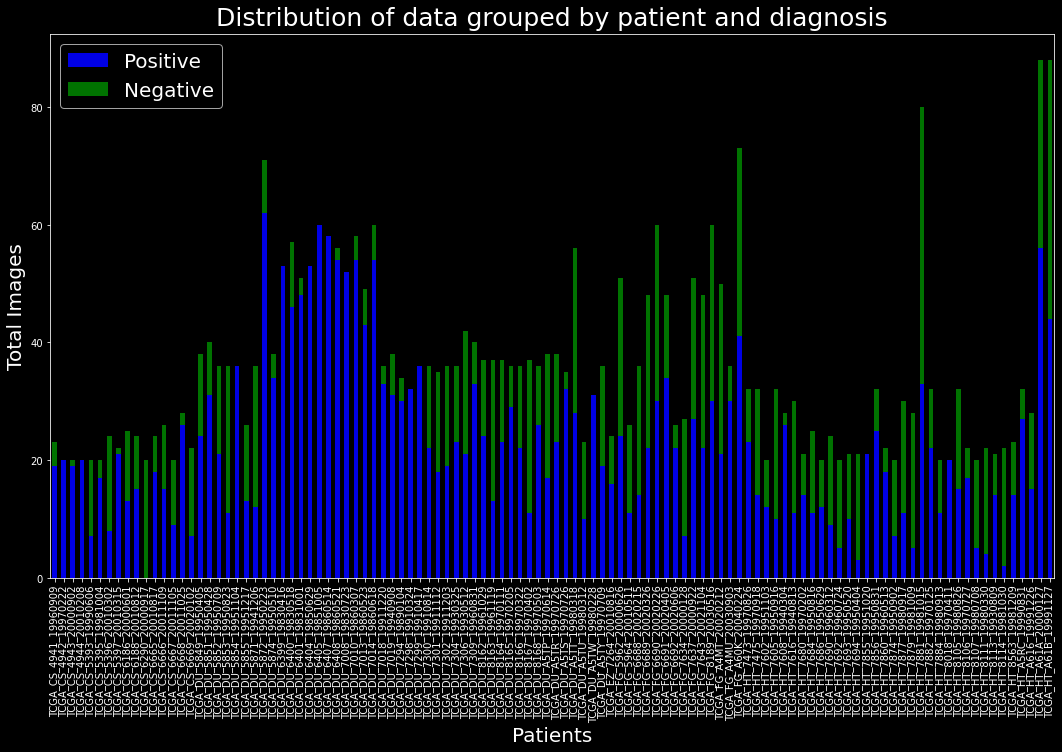

In [21]:
#GROUPING OF PATIENTS BY DIAGNOSIS
patients_by_diagnosis = brain_df.groupby(['patient_id', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["blue", "green"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

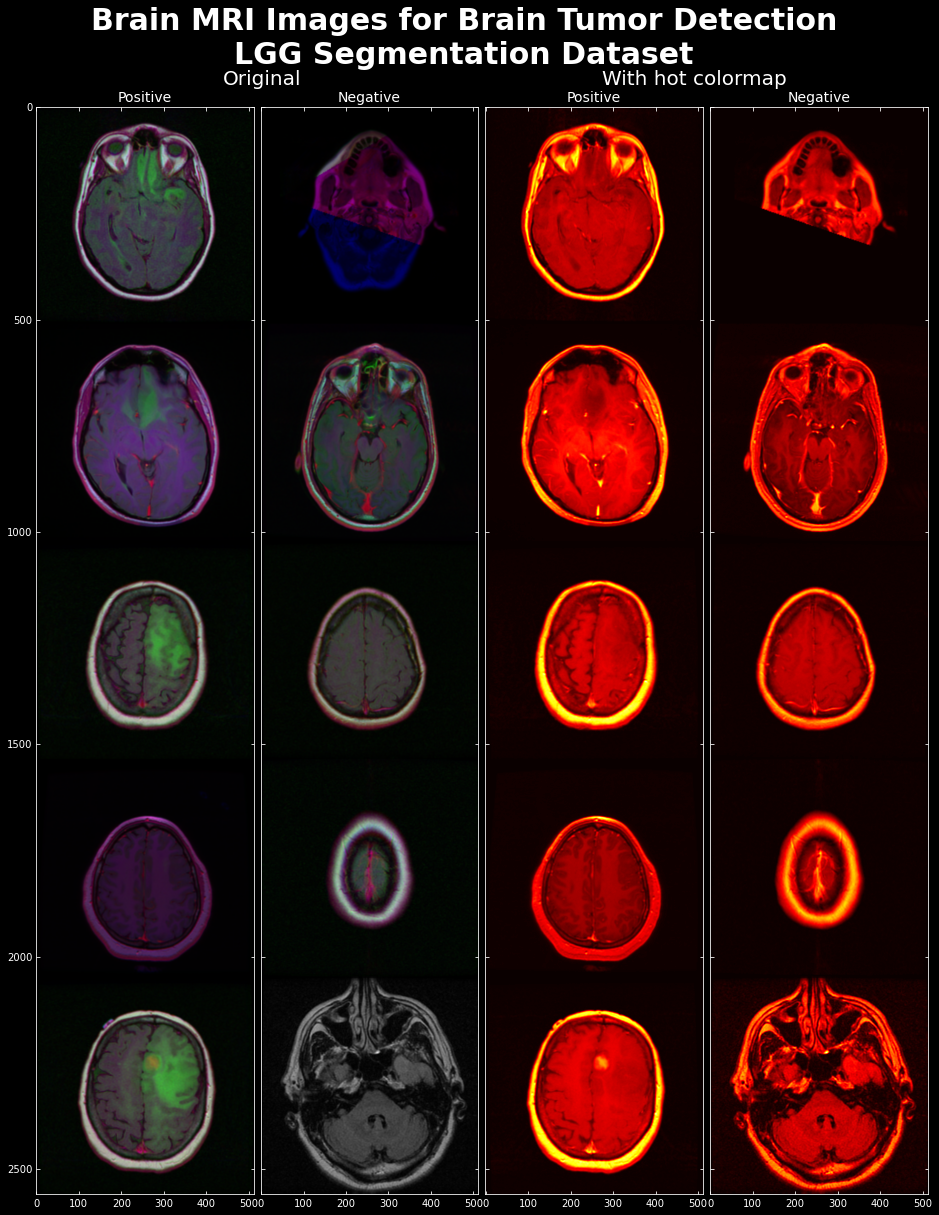

In [50]:
# Plot samples of the positive and negative data and then with hot color map to gain insights through visualisation
sample_yes_df = brain_df[brain_df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = brain_df[brain_df["diagnosis"] == 0].sample(5).image_path.values
sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])

sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=14)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=14)
grid[1].axis("off")
grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=14)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=14)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

In [28]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...   
1  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...   
2  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...   
3  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...   
4  TCGA_CS_4941_19960909  C:/Users/aisha/machine learning/lgg-mri-segmen...   

                                           mask_path  diagnosis  
0  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
1  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
2  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
3  C:/Users/aisha/machine learning/lgg-mri-segmen...          0  
4  C:/Users/aisha/machine learning/lgg-mri-segmen...          0

In [29]:
brain_df.columns

Index(['patient_id', 'image_path', 'mask_path', 'diagnosis'], dtype='object')

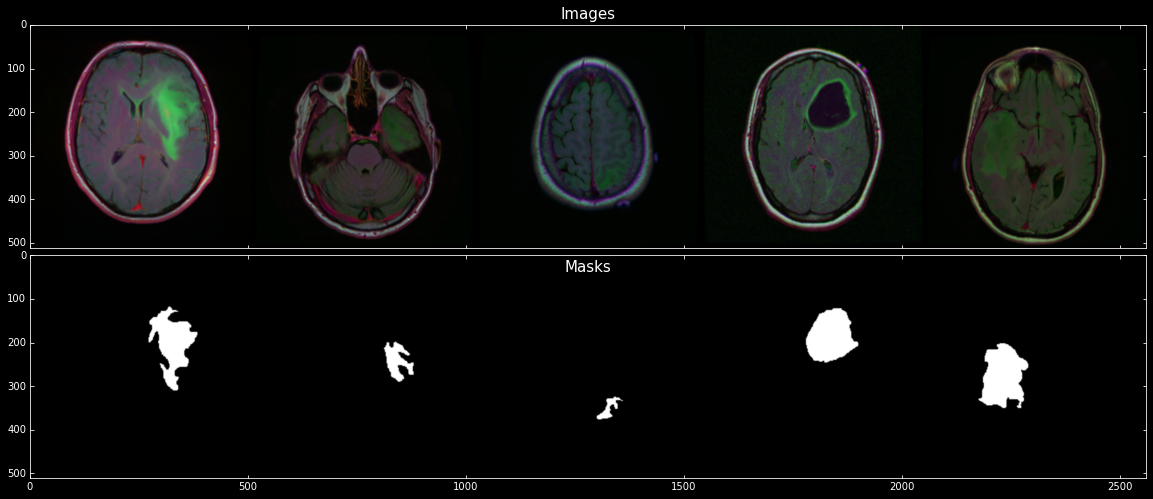

In [49]:
#plotting of images with tumors and their corresponding masks to show the exact tumor location.
sample_df = brain_df[brain_df["diagnosis"] == 1].sample(5)[['image_path', 'mask_path']].values  
sample_imgs = []

for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Then we plot the images and masks
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x1 grid of axes
                 axes_pad=0.1)  # pad between axes in inches

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")

grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")

plt.show()

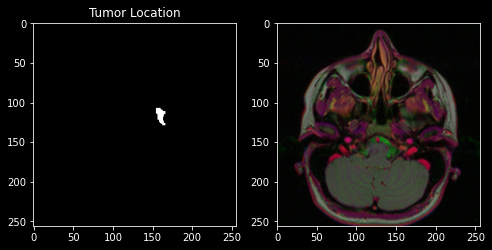

In [53]:
#Plot of a single image and it's tumor location 

for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

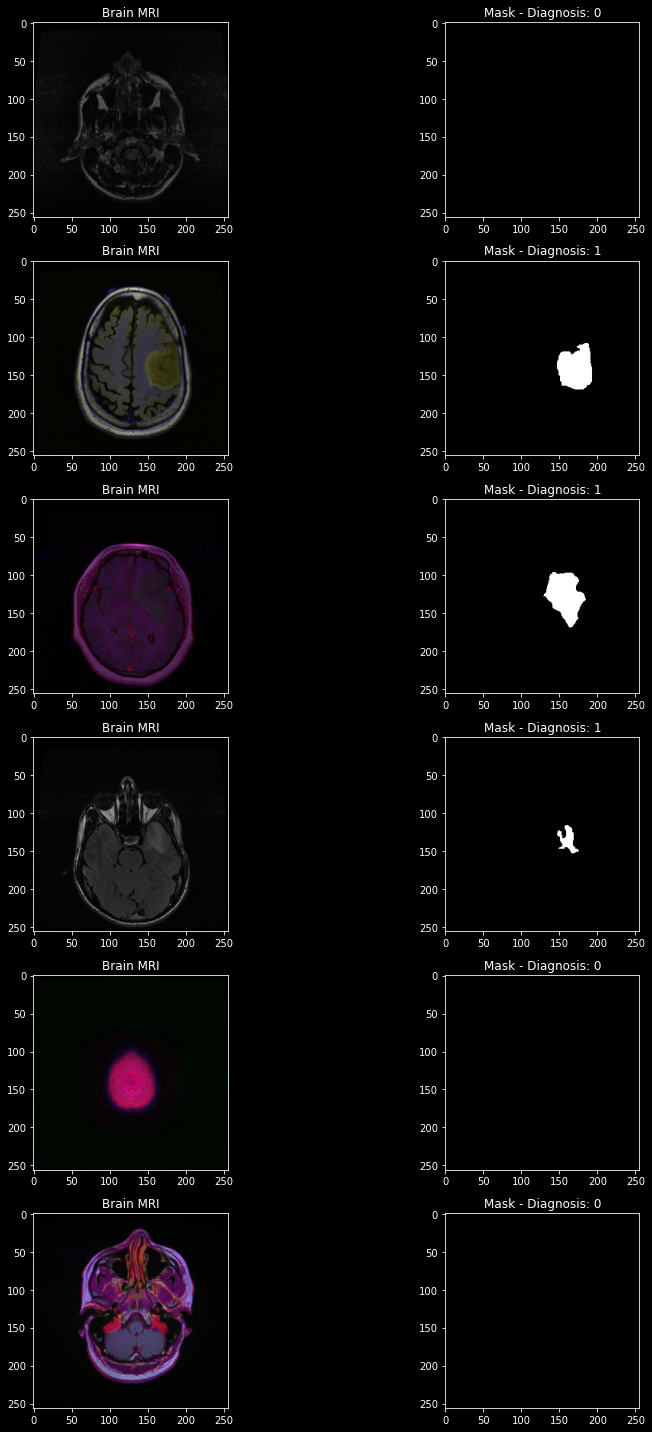

In [46]:
#Plotting of random data and their corresponding masks. 
#1 represents tumor present and 0 otherwise.
fig, axs = plt.subplots(6,2, figsize=(14,20))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df) - 1)  
    brain_img = cv2.imread(brain_df.image_path.iloc[i])
    brain_mask = cv2.imread(brain_df.mask_path.iloc[i])
    axs[count][0].imshow(brain_img)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].axis("on")
    axs[count][1].imshow(brain_mask)
    axs[count][1].title.set_text(f"Mask - Diagnosis: {brain_df['diagnosis'].iloc[i]}")
    axs[count][1].axis("on")
    
    count += 1
    
fig.tight_layout()
plt.show()

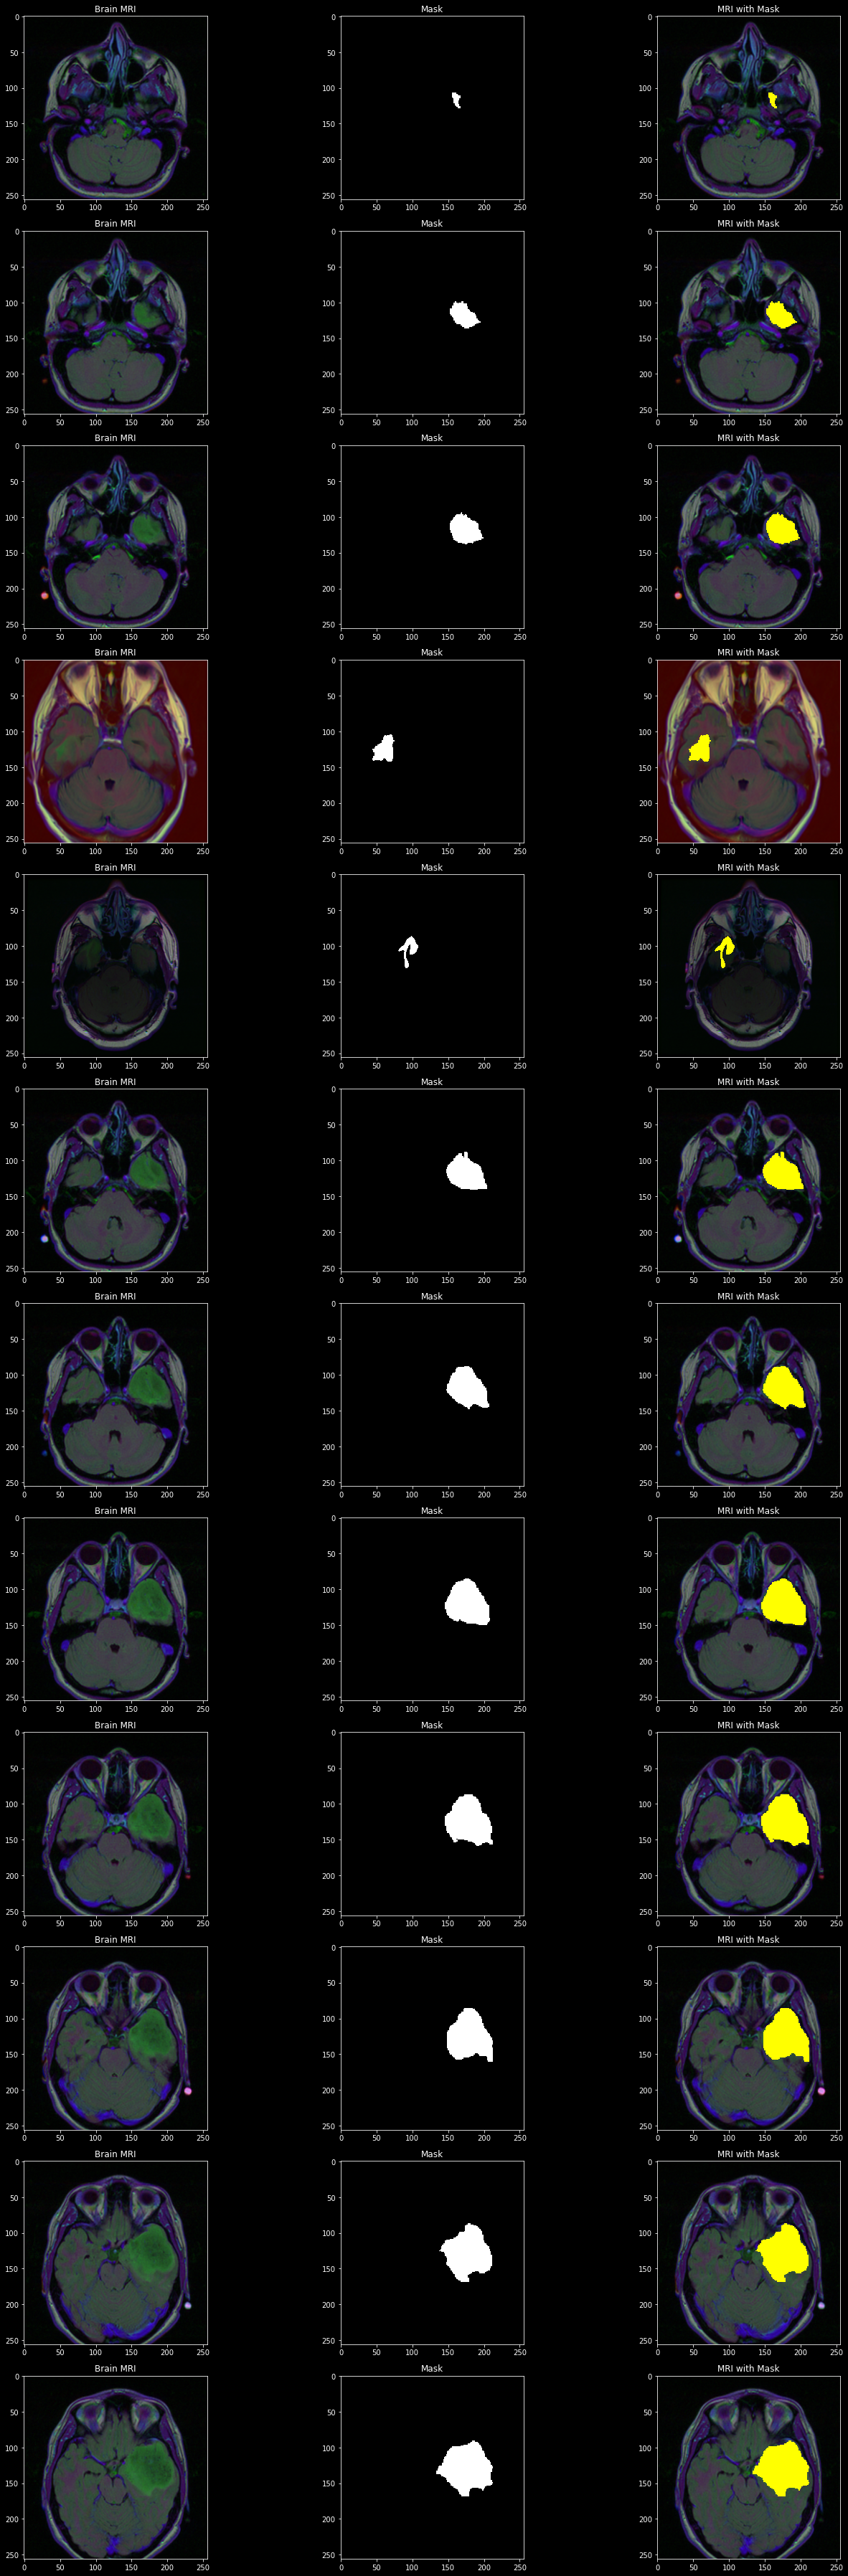

In [47]:
#plot of images with tumor present, their respective masks and highlighted tumor location on the images. 
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['diagnosis']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,255,0) 
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

In [17]:
brain_df.to_csv('brain_mri_data.csv', index=False)